In [ ]:
#get data. only need to run this if the dataset has not already been downloaded
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

--2023-02-28 03:56:22--  https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085081 (4.8M) [text/csv]
Saving to: ‘bbc_text_cls.csv’

bbc_text_cls.csv    100%[===================>]   4.85M  7.56MB/s    in 0.6s    

2023-02-28 03:56:23 (7.56 MB/s) - ‘bbc_text_cls.csv’ saved [5085081/5085081]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [ ]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#stop words for proper parsing
stops = stops.union({
    'said', 'would', 'could', 'told', 'also', 'one', 'two',
    'mr', 'new', 'year',
})

In [ ]:
#set up dataset for training
df = pd.read_csv('bbc_text_cls.csv')
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [ ]:
#compute tfidf values
vectorizer = TfidfVectorizer(stop_words=stops)
X = vectorizer.fit_transform(df['text'])

In [ ]:
#instantiate nmf model
nmf = NMF(
    n_components=10, # default: 10
    beta_loss="kullback-leibler",
    solver='mu',
    # alpha_W=0.1,
    # alpha_H=0.1,
    # l1_ratio=0.5,
    random_state=0,
)

In [ ]:
#fit to data
nmf.fit(X)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(beta_loss='kullback-leibler', n_components=10, random_state=0, solver='mu')

In [ ]:
#plots for top words by topics
def plot_top_words(model, feature_names, n_top_words=10):
  ret=[]
  fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    ret.append(top_features)    #return top words per topic

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    fig.suptitle('NMF', fontsize=40)

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()
  return ret

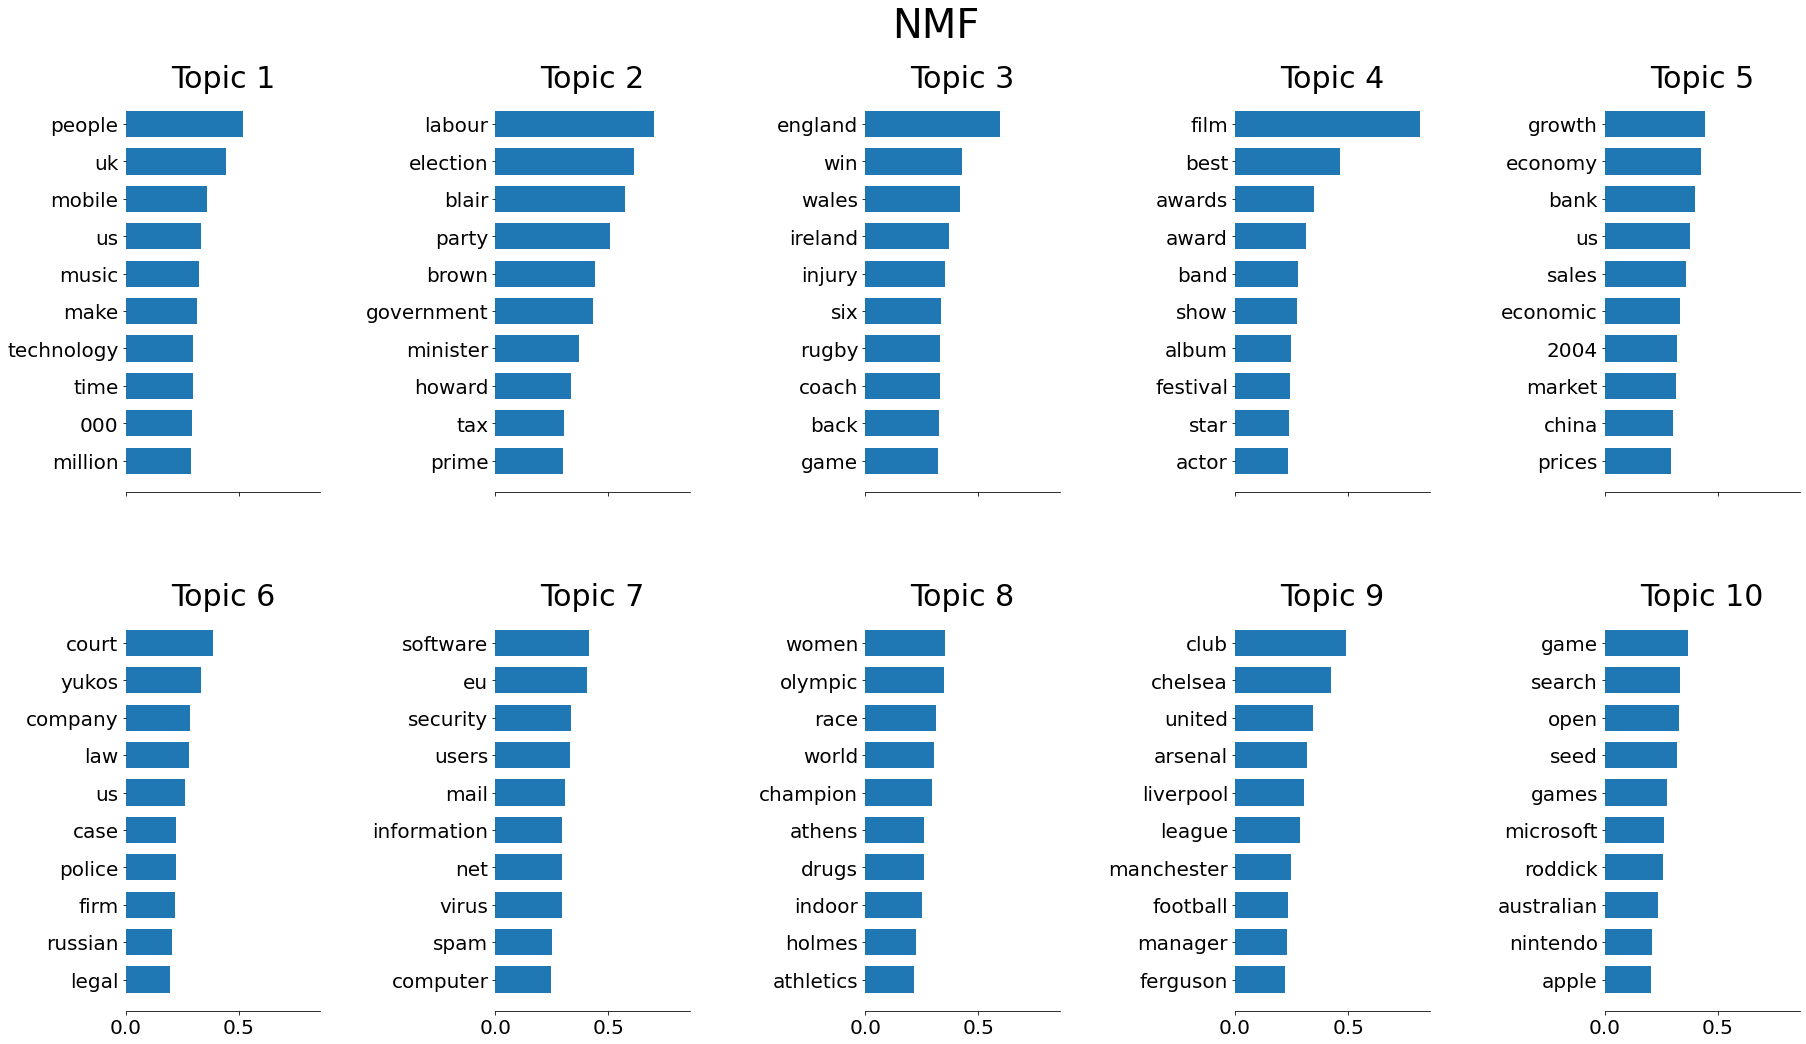

In [ ]:
# plot topics
feature_names = vectorizer.get_feature_names_out()
top_words=plot_top_words(nmf, feature_names);

In [ ]:
Z = nmf.transform(X)

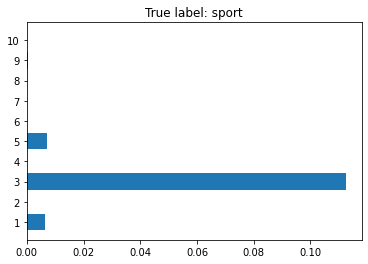

In [ ]:
# Pick a random document from dataset
# Check which "topics" are associated with it
# Check if they are related to the true label

np.random.seed(0)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(10) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels']);

In [ ]:
#print document to check results manually
def wrap(x):
  return textwrap.fill(x, replace_whitespace=False, fix_sentence_endings=True)

print(wrap(df.iloc[i]['text']))

Charvis set to lose fitness bid

Flanker Colin Charvis is unlikely to
play any part in Wales' final two games of the Six Nations.

Charvis
has missed all three of Wales' victories with an ankle injury and his
recovery has been slower than expected.  "He will not figure in the
Scotland game and is now thought unlikely to be ready for the final
game," said Wales physio Mark Davies.  Sonny Parker is continuing to
struggle with a neck injury, but Hal Luscombe should be fit for the
Murrayfield trip.  Centre Parker has only a "slim chance" of being
involved against the Scots on 13 March, so Luscombe's return to
fitness after missing the France match with hamstring trouble is a
timely boost.

Said Wales assistant coach Scott Johnson: "We're
positive about Hal and hope he'll be raring to go.  "He comes back
into the mix again, adds to the depth and gives us other options.  "
Replacement hooker Robin McBryde remains a doubt after picking up knee
ligament damage in Paris last Saturday.  "We're g

In [ ]:
#upload text file to clasify. must be only text and use UTF-8 encoding
from google.colab import files
inp=files.upload()

Saving tester.txt to tester (1).txt


In [ ]:
#make prediction for new input based on fitted model
pred=nmf.transform(vectorizer.transform([inp[next(iter(inp))].decode()])).argsort(axis=1)[:,-1]

#offset to account for indexing for topics
pred=pred+1

#print results
print('Your article is most closely associated with: Topic ' + str(pred[0]) + ':')
print(top_words[pred[0]-1])
print('Note that the keywords associated with this topic did not come from the user input file.')


Your article is most closely associated with: Topic 8:
['women', 'olympic', 'race', 'world', 'champion', 'athens', 'drugs', 'indoor', 'holmes', 'athletics']
Note that the keywords associated with this topic did not come from the user input file.
